# Website Visits: Page Loads - Median of Medians

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Analysis-and-Transformation" data-toc-modified-id="Analysis-and-Transformation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis and Transformation</a></span></li><li><span><a href="#Hyper-Parameters-Search" data-toc-modified-id="Hyper-Parameters-Search-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hyper Parameters Search</a></span></li><li><span><a href="#Training-and-Validation" data-toc-modified-id="Training-and-Validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training and Validation</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li><li><span><a href="#Test-Predictions" data-toc-modified-id="Test-Predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test Predictions</a></span></li></ul></div>

## Initialization

In [1]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [2]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

In [3]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

In [4]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

<IPython.core.display.Javascript object>

In [80]:
import os
import sys
import time
import IPython.display
from pprint import pprint
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

import timeseries as tss
from timeseries import plot_ts
from timeseries.analysis import acf, pacf, plot_hist, plot_acf, plot_pacf, plot_stats
from timeseries.transform import (
    IHSTransformer,
    get_smoothed,
    get_downsampled,
    get_interpolated,
)
from timeseries.forecast.utils import Results
from timeseries.forecast.utils import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from timeseries.forecast.scorings import get_comparison_scorings
from timeseries.forecast import average_scores
from timeseries.forecast.hyper_params import (
    make_grid,
    grid_search_hyper_params,
    print_hyper_scores,
    sorted_scores,
)
from timeseries.forecast.models import (
    SarimaModel,
    sarima_model_version,
    sarima_model_version_str,
)

from timeseries_data import WebsiteVisitsData

<IPython.core.display.Javascript object>

In [6]:
import nb_black

from notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [7]:
scorings = get_comparison_scorings()

ts_data = WebsiteVisitsData()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")
test_results = Results(data_type, data_name, "test")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

## Analysis and Transformation

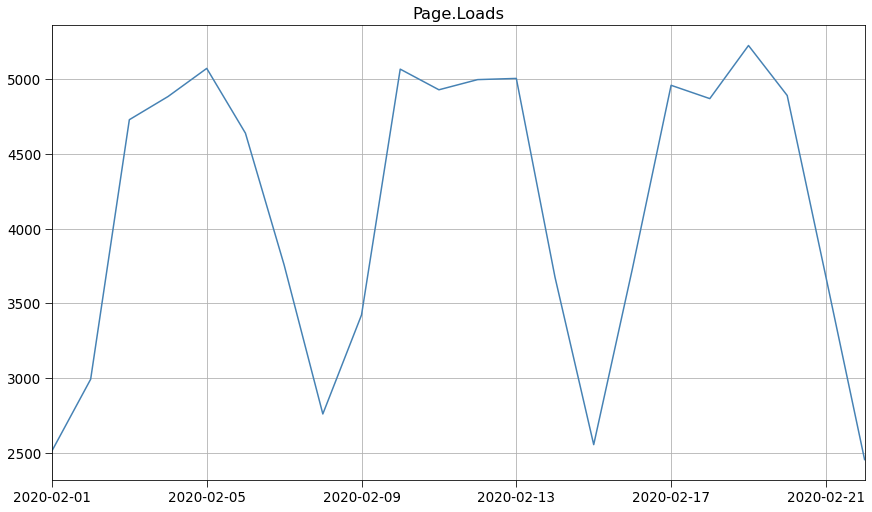

<IPython.core.display.Javascript object>

In [12]:
plot_ts(ts[datetime(2020, 2, 1) : datetime(2020, 2, 22)])

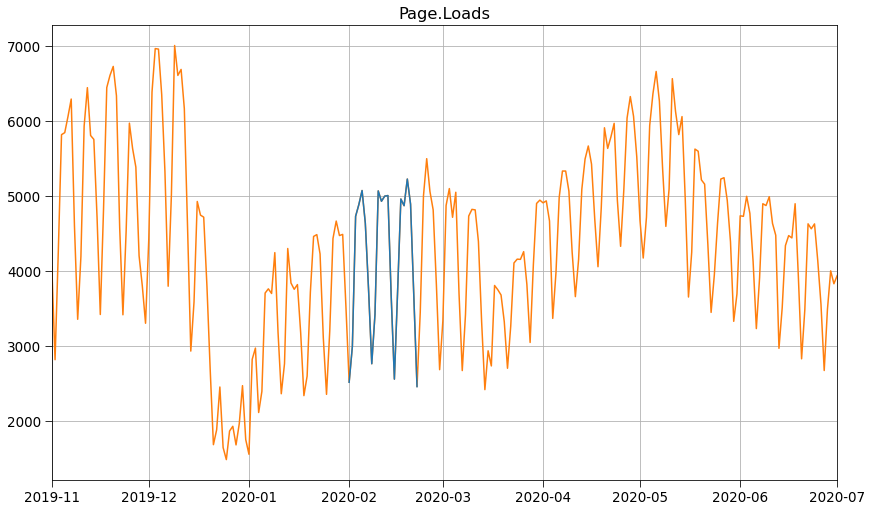

<IPython.core.display.Javascript object>

In [40]:
fig = plot_ts(ts[datetime(2019, 11, 1) : datetime(2020, 7, 1)], color="tab:orange")
plot_ts(ts[datetime(2020, 2, 1) : datetime(2020, 2, 22)], color="tab:blue", fig=fig)
display(fig)

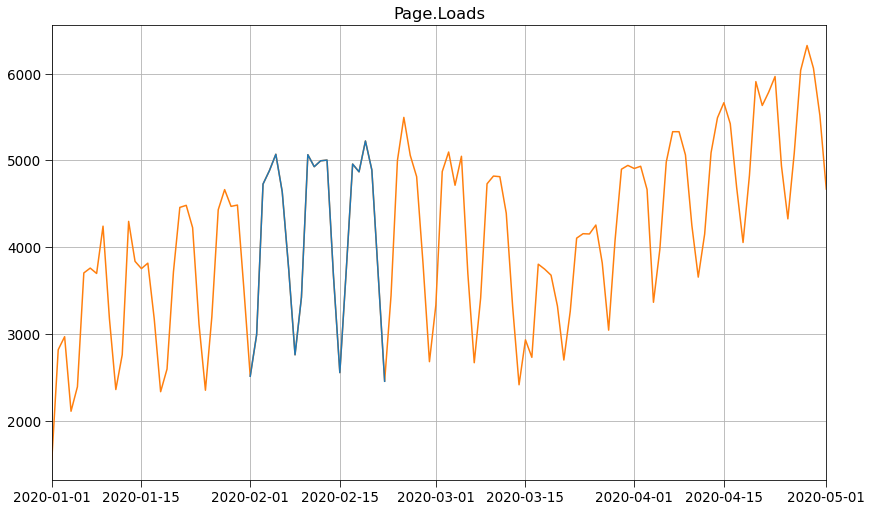

<IPython.core.display.Javascript object>

In [42]:
fig = plot_ts(ts[datetime(2020, 1, 1) : datetime(2020, 5, 1)], color="tab:orange")
plot_ts(ts[datetime(2020, 2, 1) : datetime(2020, 2, 22)], color="tab:blue", fig=fig)
display(fig)

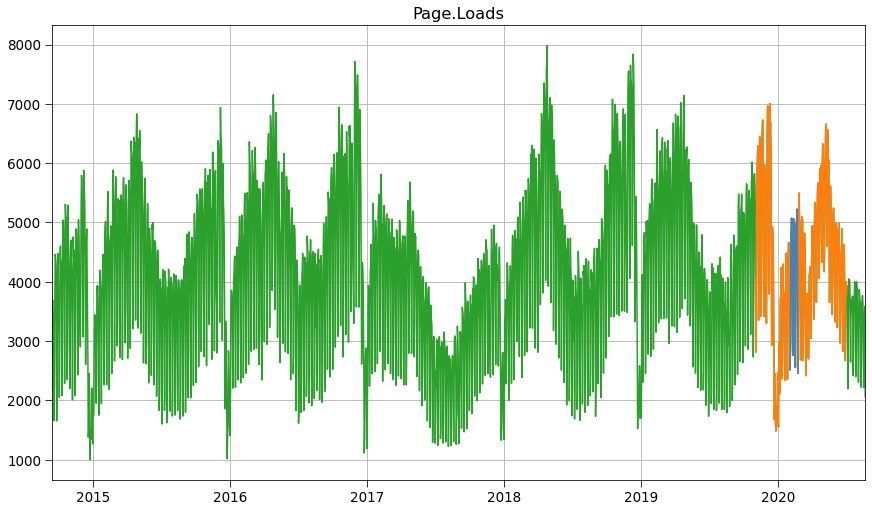

<IPython.core.display.Javascript object>

In [17]:
fig = plot_ts(ts, color="tab:green")
plot_ts(ts[datetime(2019, 11, 1) : datetime(2020, 7, 1)], color="tab:orange", fig=fig)
plot_ts(ts[datetime(2020, 2, 1) : datetime(2020, 2, 22)], fig=fig)
display(fig)

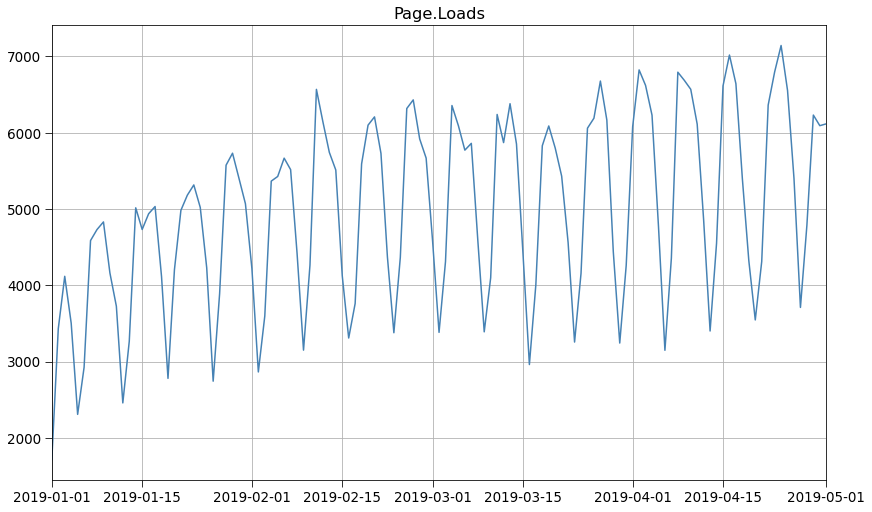

<IPython.core.display.Javascript object>

In [41]:
fig = plot_ts(ts[datetime(2019, 1, 1) : datetime(2019, 5, 1)])
display(fig)

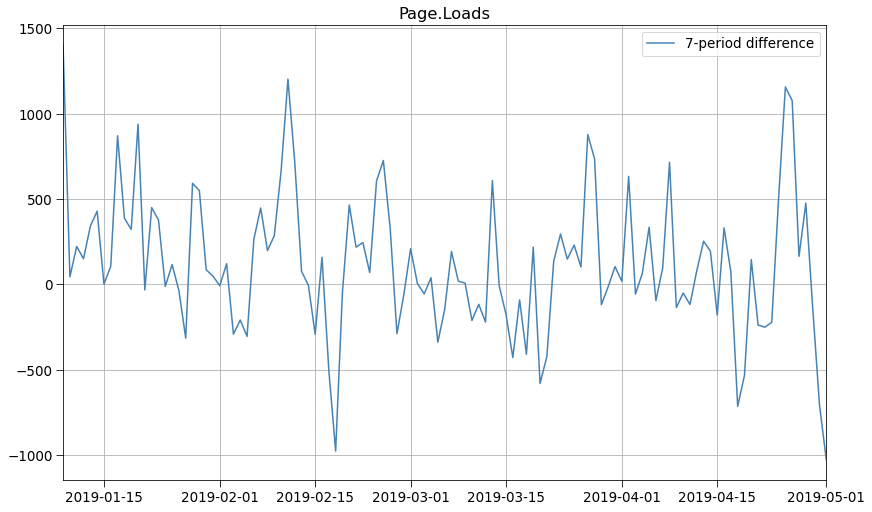

<IPython.core.display.Javascript object>

In [50]:
fig = plot_ts(
    ts[datetime(2019, 1, 1) : datetime(2019, 5, 1)].diff(7).iloc[8:],
    name="7-period difference",
)
display(fig)

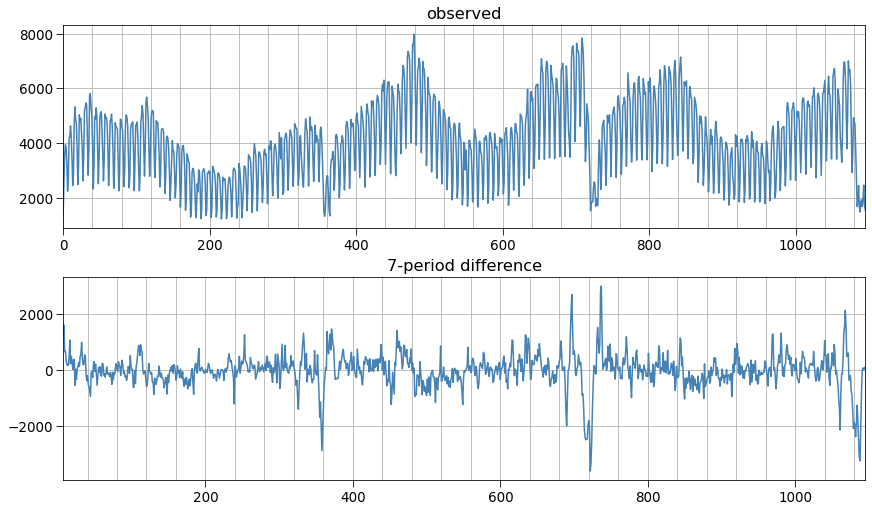

<IPython.core.display.Javascript object>

In [52]:
observed = pd.Series(ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)], name="observed")
seven_period_diffs = pd.Series(
    ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)].diff(7), name="7-period difference"
)
plot_ts([observed, seven_period_diffs], ax_height=200)

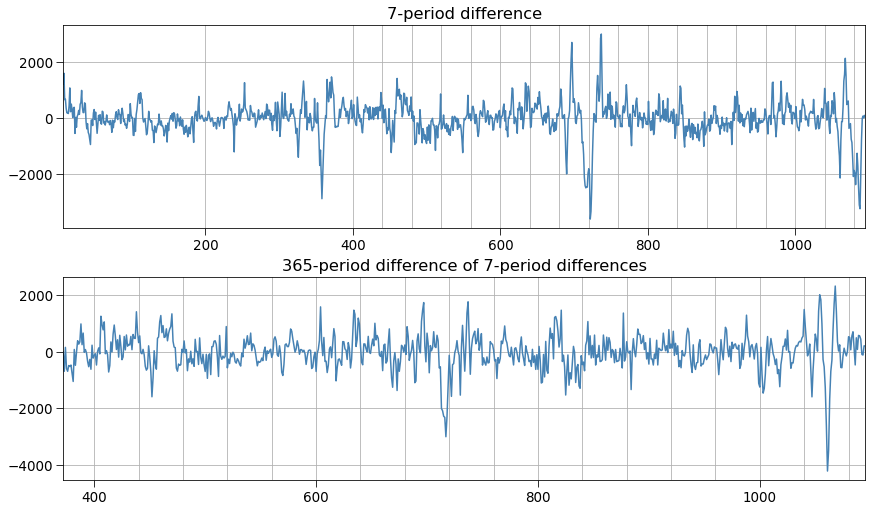

<IPython.core.display.Javascript object>

In [54]:
seven_period_diffs = pd.Series(
    ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)].diff(7), name="7-period difference"
)
seven_and365_periods_diffs = pd.Series(
    ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)].diff(365).diff(7),
    name="365-period difference of 7-period differences",
)
plot_ts([seven_period_diffs, seven_and365_periods_diffs], ax_height=200)

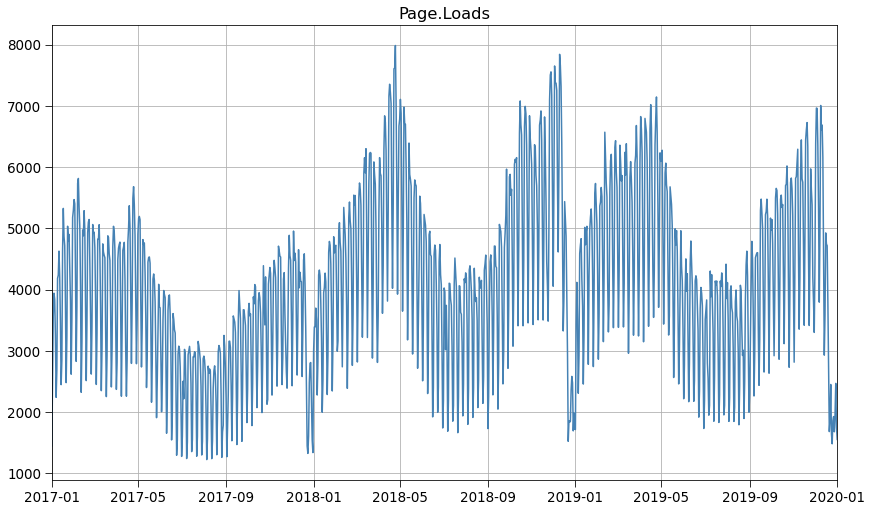

<IPython.core.display.Javascript object>

In [51]:
plot_ts(ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)])

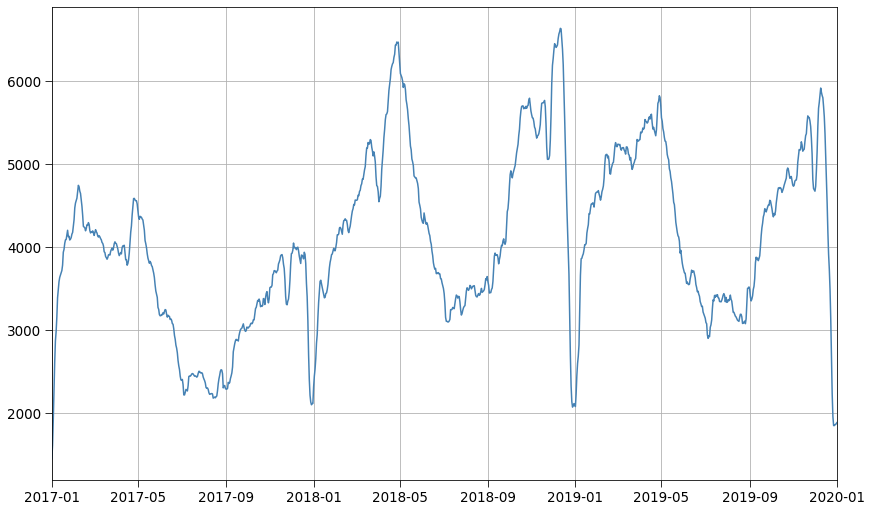

<IPython.core.display.Javascript object>

In [78]:
plot_ts(
    get_smoothed(
        ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)].astype(float),
        weights=np.array([1 for _ in range(13)]),
    )
)

In [97]:
ts2 = get_smoothed(
    get_interpolated(
        get_downsampled(
            get_smoothed(
                ts[datetime(2018, 12, 20) : datetime(2019, 5, 13)].astype(float),
                weights=np.array([1 for _ in range(13)]),
            ),
            timedelta(days=7),
        ),
        tss.Interval(ts, datetime(2019, 1, 1), datetime(2019, 5, 2)),
    ),
    std=7,
)
ts3 = ts[datetime(2019, 1, 1) : datetime(2019, 5, 1)] - ts2

<IPython.core.display.Javascript object>

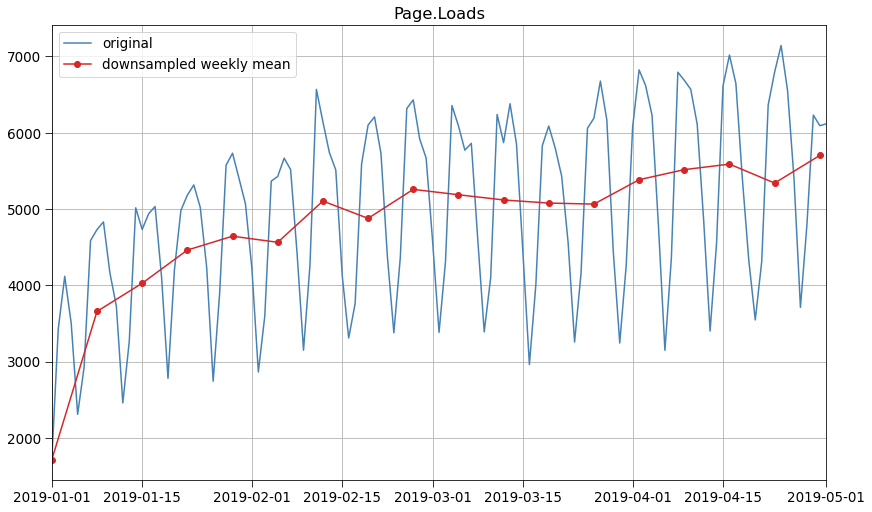

<IPython.core.display.Javascript object>

In [107]:
ts1 = get_downsampled(
    get_smoothed(
        ts[datetime(2019, 1, 1) : datetime(2019, 5, 1)].astype(float),
        weights=np.array([1 for _ in range(13)]),
    ),
    timedelta(days=7),
)

fig = plot_ts(
    ts[datetime(2019, 1, 1) : datetime(2019, 5, 1)].astype(float), name="original"
)
# plot_ts(
#     ts2,
#     fig=fig,
#     color="tab:red",
#     name="downsampled with means",
# )
plot_ts(ts1, fig=fig, color="tab:red", name="downsampled weekly mean", marker="o")
fig

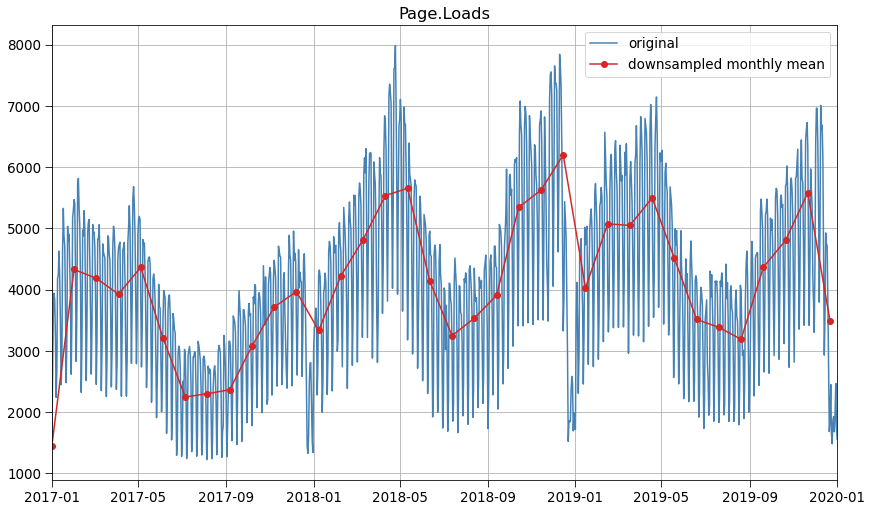

<IPython.core.display.Javascript object>

In [106]:
ts1 = get_downsampled(
    get_smoothed(
        ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)].astype(float),
        weights=np.array([1 for _ in range(13)]),
    ),
    timedelta(days=31),
)

fig = plot_ts(
    ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)].astype(float), name="original"
)
# plot_ts(
#     ts2,
#     fig=fig,
#     color="tab:red",
#     name="downsampled with means",
# )
plot_ts(ts1, fig=fig, color="tab:red", name="downsampled monthly mean", marker="o")
fig

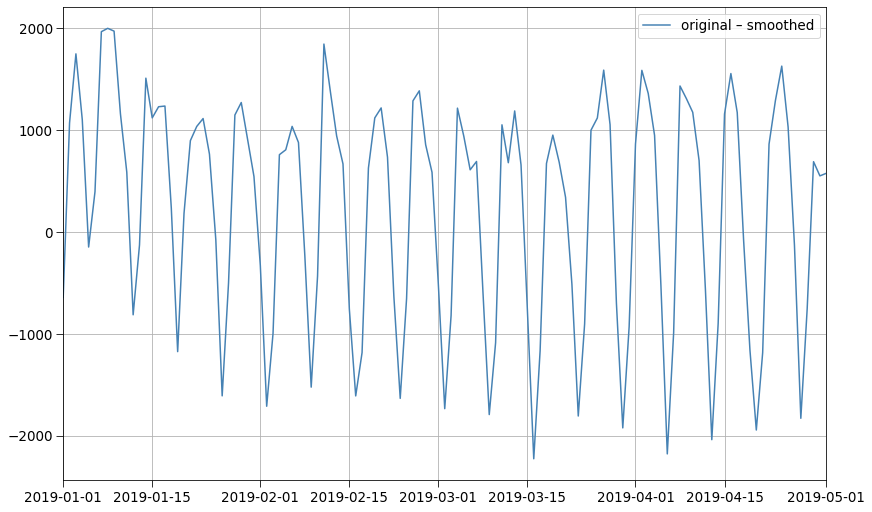

<IPython.core.display.Javascript object>

In [94]:
fig = plot_ts(ts3, name="original – smoothed")
fig

In [64]:
[1 / 7 for _ in range(7)]

[0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285,
 0.14285714285714285]

<IPython.core.display.Javascript object>

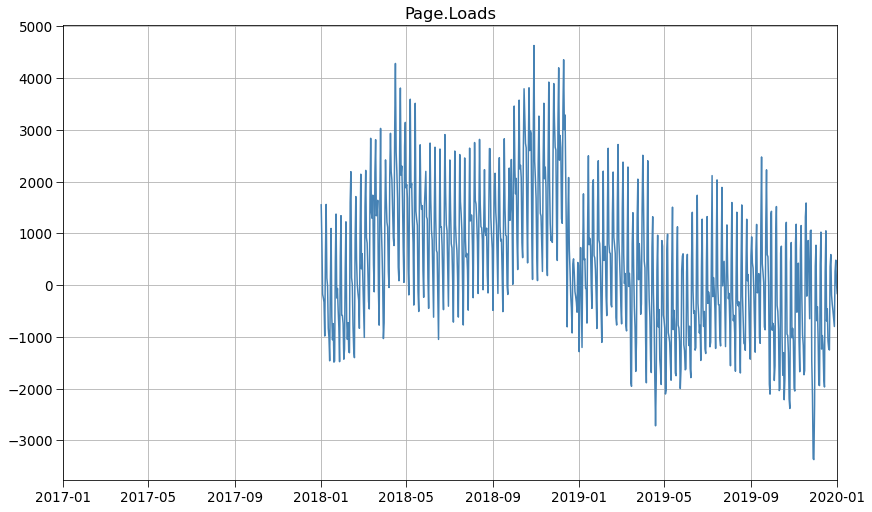

<IPython.core.display.Javascript object>

In [39]:
plot_ts(ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)].diff(365))

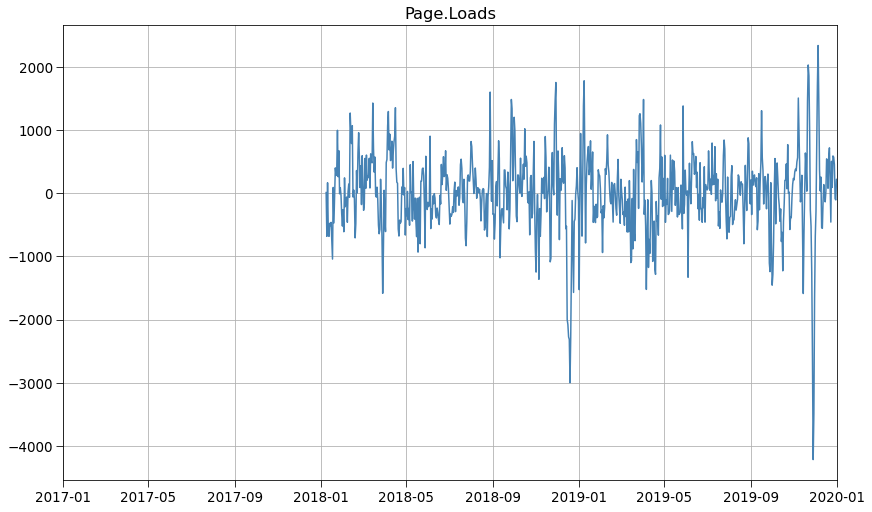

<IPython.core.display.Javascript object>

In [40]:
plot_ts(ts[datetime(2017, 1, 1) : datetime(2020, 1, 1)].diff(365).diff(7))

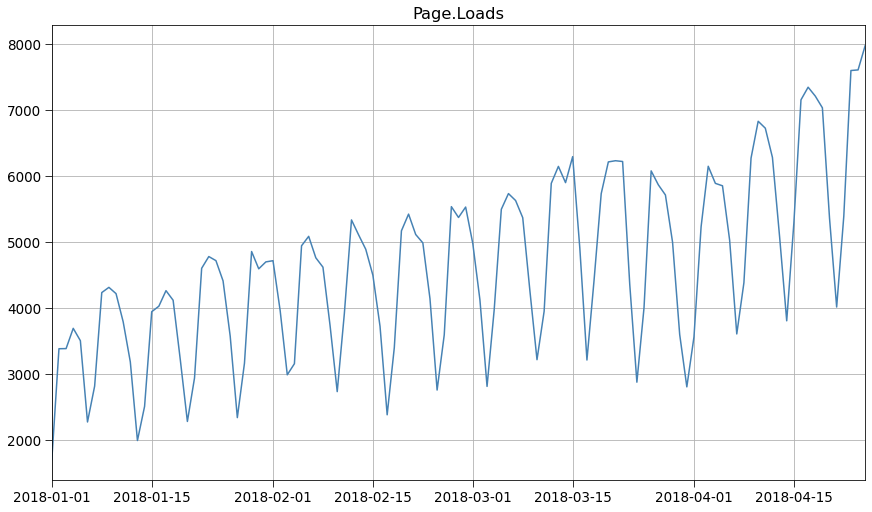

<IPython.core.display.Javascript object>

In [8]:
plot_ts(ts[datetime(2018, 1, 1) : datetime(2018, 4, 25)])

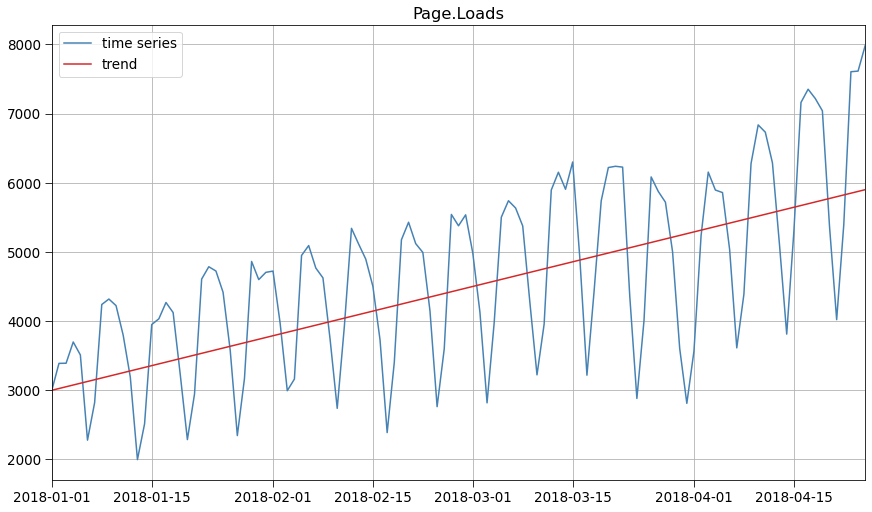

<IPython.core.display.Javascript object>

In [33]:
# 2500 --- 6000
# 01-01 --- 25-04
low = 3000
high = 5900
begin = datetime(2018, 1, 1)
end = datetime(2018, 4, 25)
trend = ts[begin:end]
for d in trend.index:
    trend.loc[d] = (
        low + (high - low) / (end - begin).total_seconds() * (d - begin).total_seconds()
    )
fig = plot_ts(ts[datetime(2018, 1, 1) : datetime(2018, 4, 25)], name="time series")
plot_ts(trend, color="tab:red", name="trend", fig=fig)

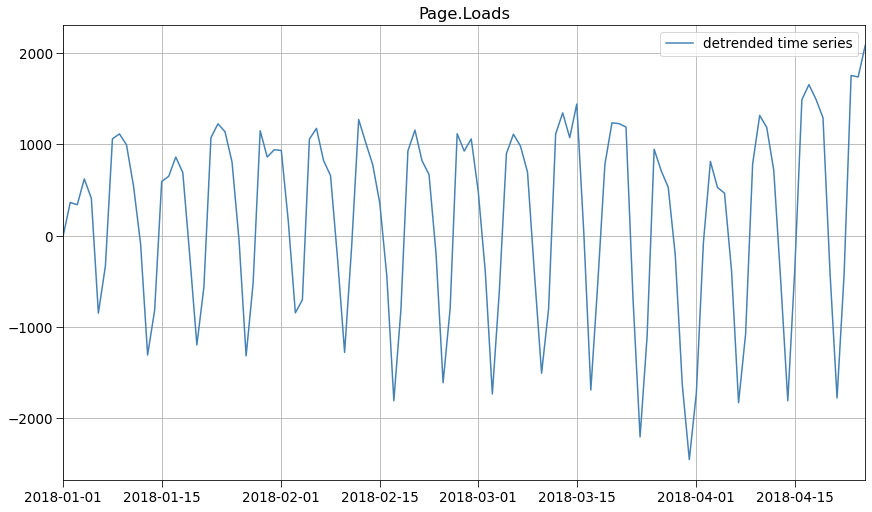

<IPython.core.display.Javascript object>

In [34]:
plot_ts(
    ts[datetime(2018, 1, 1) : datetime(2018, 4, 25)] - trend,
    name="detrended time series",
)

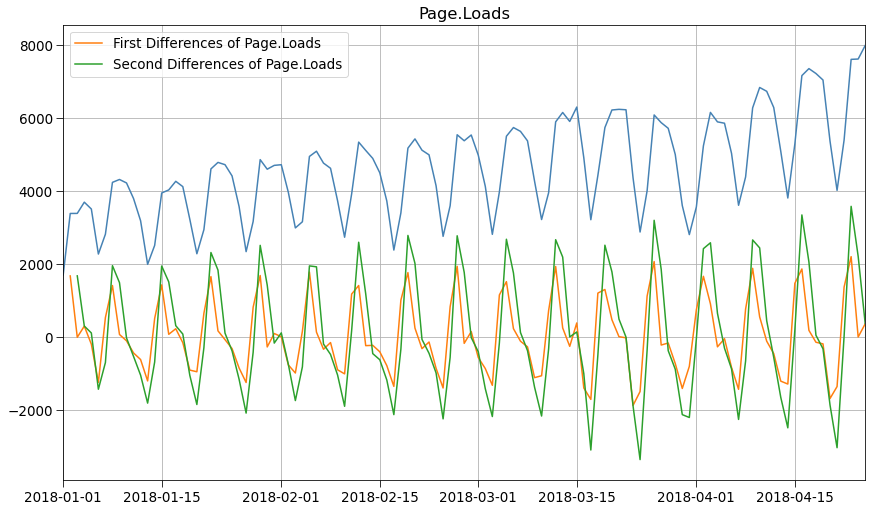

<IPython.core.display.Javascript object>

In [39]:
fig = plot_ts(ts[datetime(2018, 1, 1) : datetime(2018, 4, 25)])
plot_ts(
    ts[datetime(2018, 1, 1) : datetime(2018, 4, 25)].diff(),
    name="First Differences of Page.Loads",
    fig=fig,
    color="tab:orange",
)
plot_ts(
    ts[datetime(2018, 1, 1) : datetime(2018, 4, 25)].diff(2),
    name="Second Differences of Page.Loads",
    fig=fig,
    color="tab:green",
)
display(fig)

Order of differencing: 1
MLE of IHS lambda cannot be found


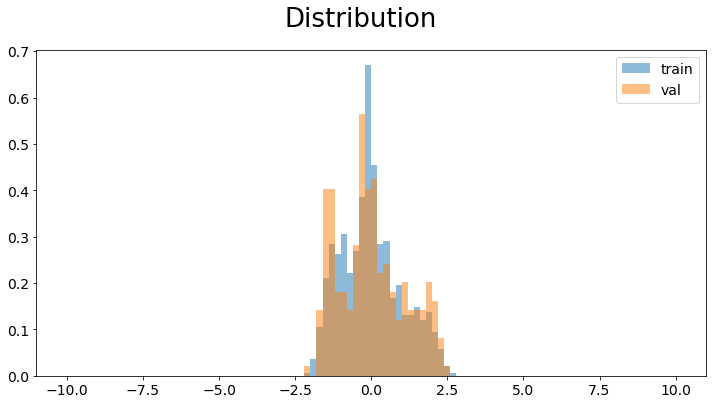

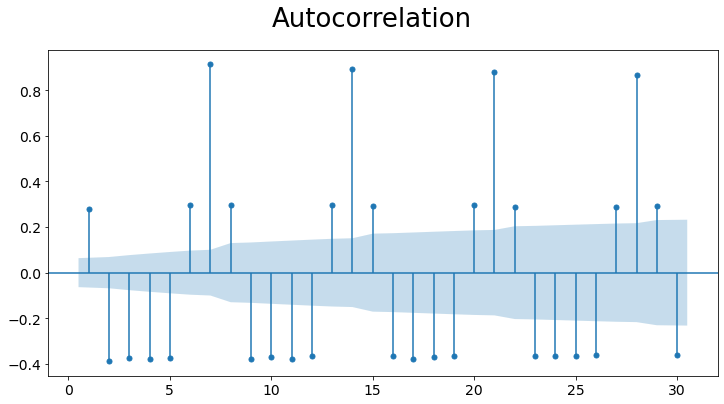

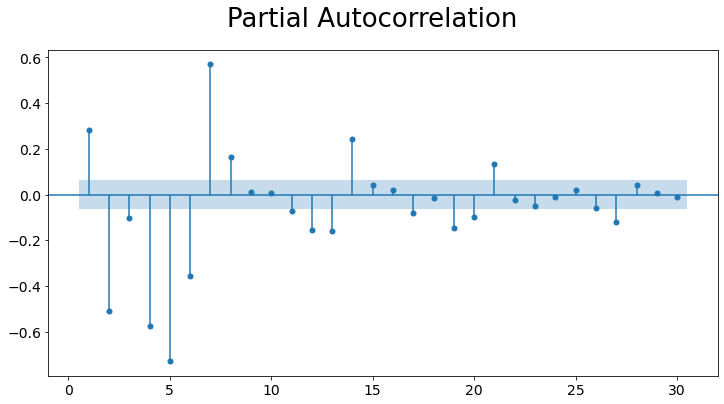

<IPython.core.display.Javascript object>

In [41]:
trans = IHSTransformer(train_intv.view(ts), verbose=True)
original_trans_ts = trans_ts = trans.transform(ts)

fig = plot_hist(
    train_intv.view(trans_ts), bins=100, range=(-10, 10), density=True, name="train"
)
display(
    plot_hist(
        val_intv.view(trans_ts),
        bins=100,
        range=(-10, 10),
        density=True,
        name="val",
        fig=fig,
        title="Distribution",
    )
)

alpha = 0.05
display(plot_acf(train_intv.view(trans_ts), alpha=alpha, zero=False))
display(plot_pacf(train_intv.view(trans_ts), alpha=alpha, zero=False))

In [42]:
len(train_intv.view(trans_ts))

948

<IPython.core.display.Javascript object>

In [43]:
trans_ts_acf, _ = acf(train_intv.view(trans_ts), nlags=30, alpha=alpha)
(trans_ts_acf_idx,) = np.where(np.abs(trans_ts_acf) >= 0.1)

trans_ts_pacf, _ = pacf(train_intv.view(trans_ts), nlags=30, alpha=alpha)
(trans_ts_pacf_idx,) = np.where(np.abs(trans_ts_pacf) >= 0.1)

print(f"acf: {trans_ts_acf_idx}")
print(f"pacf: {trans_ts_pacf_idx}")

acf: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
pacf: [ 0  1  2  3  4  5  6  7  8 12 13 14 19 21 27]


<IPython.core.display.Javascript object>

## Hyper Parameters Search

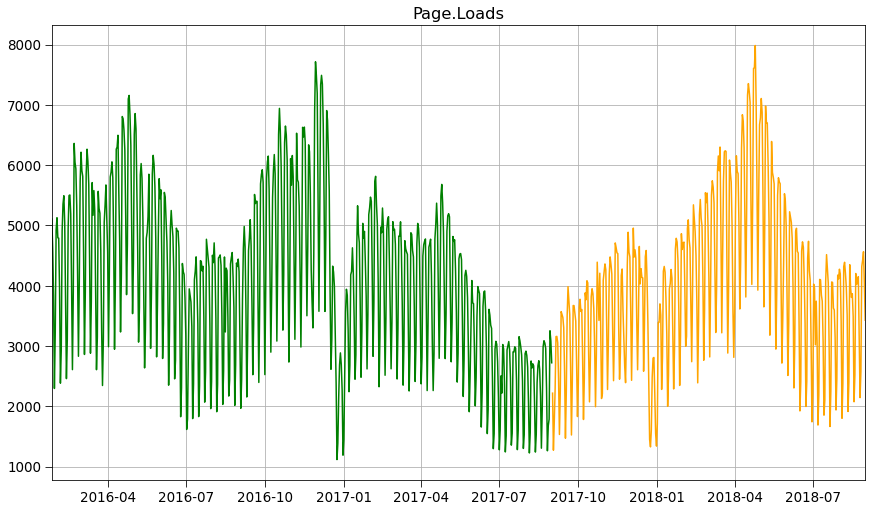

<IPython.core.display.Javascript object>

In [14]:
hyper_search_train_datetime = train_intv.begin
hyper_search_val_datetime = datetime(2017, 9, 1)
hyper_search_end_val_datetime = val_intv.begin
hyper_search_train_intv = tss.Interval(
    ts, hyper_search_train_datetime, hyper_search_val_datetime
)
hyper_search_val_intv = tss.Interval(
    ts, hyper_search_val_datetime, hyper_search_end_val_datetime
)
fig = plot_ts(hyper_search_train_intv.view(), color="green")
display(plot_ts(hyper_search_val_intv.view(), fig=fig, color="orange"))

In [11]:
def sarima_grid_search(scores=None):
    return grid_search_hyper_params(
        SarimaModel,
        grid,
        trans_ts,
        hyper_search_train_intv,
        hyper_search_val_intv,
        model_params=model_params,
        score_params=score_params,
        fit_params=fit_params,
        best=None,
        scores=scores,
    )

<IPython.core.display.Javascript object>

In [12]:
score_params = dict(
    scorings=["mae"],
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=10,
    mute=True,
)

fit_params = dict(scoring="mae")

<IPython.core.display.Javascript object>

In [14]:
%%time
p_range = trans_ts_pacf_idx
q_range = [0, 1, 2, 3, 4, 5, 6, 7, 8]
D_range = [0, 1, 2]
grid = make_grid(p=p_range, q=q_range, D=D_range)

model_params = dict(d=0, s=7)

sarima_grid_search_scores = sarima_grid_search()
    
pprint(sarima_grid_search_scores[:10])

the best of all: 323.097118 (p=3, q=8, D=1)                                                                   


[(323.0971178279831, {'D': 1, 'p': 3, 'q': 8}),
 (325.27811295332776, {'D': 1, 'p': 7, 'q': 7}),
 (325.3019449059095, {'D': 1, 'p': 5, 'q': 8}),
 (325.53017751222586, {'D': 1, 'p': 3, 'q': 7}),
 (325.91500104290367, {'D': 1, 'p': 4, 'q': 7}),
 (326.27930976805135, {'D': 1, 'p': 2, 'q': 8}),
 (327.4616023978247, {'D': 1, 'p': 4, 'q': 8}),
 (327.49191974450775, {'D': 1, 'p': 2, 'q': 7}),
 (327.5879665761812, {'D': 1, 'p': 0, 'q': 8}),
 (328.21571914383867, {'D': 0, 'p': 5, 'q': 6})]
CPU times: user 18h 21s, sys: 14h 16min 7s, total: 1d 8h 16min 29s
Wall time: 1d 20min 58s


<IPython.core.display.Javascript object>

In [1]:
sarima_grid_search_scores = [(323.0971178279831, {'D': 1, 'p': 3, 'P': 0, 'q': 8}),
 (325.27811295332776, {'D': 1, 'p': 7, 'P': 0, 'q': 7}),
 (325.3019449059095, {'D': 1, 'p': 5, 'P': 0, 'q': 8}),
 (325.53017751222586, {'D': 1, 'p': 3, 'P': 0, 'q': 7}),
 (325.91500104290367, {'D': 1, 'p': 4, 'P': 0, 'q': 7}),
 (326.27930976805135, {'D': 1, 'p': 2, 'P': 0, 'q': 8}),
 (327.4616023978247, {'D': 1, 'p': 4, 'P': 0, 'q': 8}),
 (327.49191974450775, {'D': 1, 'p': 2, 'P': 0, 'q': 7}),
 (327.5879665761812, {'D': 1, 'p': 0, 'P': 0, 'q': 8}),
 (328.21571914383867, {'D': 0, 'p': 5, 'P': 0, 'q': 6})]

In [16]:
%%time
p_range = [0, 1, 2, 3, 4, 5, 6]
q_range = [0, 1, 2, 3, 4, 5, 6]
D_range = [1]
P_range = [1, 2]
grid = make_grid(p=p_range, q=q_range, D=D_range, P=P_range)

model_params = dict(d=0, s=7)

sarima_grid_search_scores = sarima_grid_search(sarima_grid_search_scores)
    
pprint(sarima_grid_search_scores[:10])

the best of all: 323.097118 (D=1, p=3, P=0, q=8)                                                              


[(323.0971178279831, {'D': 1, 'P': 0, 'p': 3, 'q': 8}),
 (325.27811295332776, {'D': 1, 'P': 0, 'p': 7, 'q': 7}),
 (325.3019449059095, {'D': 1, 'P': 0, 'p': 5, 'q': 8}),
 (325.53017751222586, {'D': 1, 'P': 0, 'p': 3, 'q': 7}),
 (325.91500104290367, {'D': 1, 'P': 0, 'p': 4, 'q': 7}),
 (326.27930976805135, {'D': 1, 'P': 0, 'p': 2, 'q': 8}),
 (327.4616023978247, {'D': 1, 'P': 0, 'p': 4, 'q': 8}),
 (327.49191974450775, {'D': 1, 'P': 0, 'p': 2, 'q': 7}),
 (327.5879665761812, {'D': 1, 'P': 0, 'p': 0, 'q': 8}),
 (328.21571914383867, {'D': 0, 'P': 0, 'p': 5, 'q': 6})]
CPU times: user 1h 54min 21s, sys: 1h 28min 38s, total: 3h 23min
Wall time: 3h 15s


<IPython.core.display.Javascript object>

In [17]:
sarima_grid_search_scores

[(323.0971178279831, {'D': 1, 'p': 3, 'P': 0, 'q': 8}),
 (325.27811295332776, {'D': 1, 'p': 7, 'P': 0, 'q': 7}),
 (325.3019449059095, {'D': 1, 'p': 5, 'P': 0, 'q': 8}),
 (325.53017751222586, {'D': 1, 'p': 3, 'P': 0, 'q': 7}),
 (325.91500104290367, {'D': 1, 'p': 4, 'P': 0, 'q': 7}),
 (326.27930976805135, {'D': 1, 'p': 2, 'P': 0, 'q': 8}),
 (327.4616023978247, {'D': 1, 'p': 4, 'P': 0, 'q': 8}),
 (327.49191974450775, {'D': 1, 'p': 2, 'P': 0, 'q': 7}),
 (327.5879665761812, {'D': 1, 'p': 0, 'P': 0, 'q': 8}),
 (328.21571914383867, {'D': 0, 'p': 5, 'P': 0, 'q': 6}),
 (332.4689118412741, {'p': 0, 'q': 8, 'D': 1, 'P': 1}),
 (338.40732469300013, {'p': 6, 'q': 3, 'D': 1, 'P': 2}),
 (339.72999822329064, {'p': 5, 'q': 6, 'D': 1, 'P': 2}),
 (339.79070895543856, {'p': 6, 'q': 5, 'D': 1, 'P': 2}),
 (341.4900454590073, {'p': 6, 'q': 6, 'D': 1, 'P': 2}),
 (344.6333157309957, {'p': 3, 'q': 2, 'D': 1, 'P': 2}),
 (344.65159019340945, {'p': 6, 'q': 4, 'D': 1, 'P': 2}),
 (348.53631412138003, {'p': 5, 'q': 6,

<IPython.core.display.Javascript object>

In [21]:
[
    (s, v)
    for (s, v) in sarima_grid_search_scores
    if v["p"] + v["q"] + v["P"] + v["D"] <= 6
]

[(371.79106885824945, {'p': 0, 'q': 3, 'D': 1, 'P': 2}),
 (372.5491620004183, {'p': 0, 'q': 2, 'D': 1, 'P': 2}),
 (373.65919905438733, {'p': 1, 'q': 2, 'D': 1, 'P': 2}),
 (374.27693751121546, {'p': 3, 'q': 0, 'D': 1, 'P': 2}),
 (374.7483204301509, {'p': 2, 'q': 1, 'D': 1, 'P': 2}),
 (375.7593743319954, {'p': 1, 'q': 1, 'D': 1, 'P': 2}),
 (377.76913435701056, {'p': 2, 'q': 0, 'D': 1, 'P': 2}),
 (380.4098320933986, {'p': 0, 'q': 1, 'D': 1, 'P': 2}),
 (389.0246048448756, {'p': 1, 'q': 0, 'D': 1, 'P': 2}),
 (403.628931594172, {'p': 0, 'q': 0, 'D': 1, 'P': 2}),
 (414.9292681206817, {'p': 1, 'q': 1, 'D': 1, 'P': 1}),
 (415.0512141844394, {'p': 1, 'q': 3, 'D': 1, 'P': 1}),
 (415.1616857038848, {'p': 0, 'q': 2, 'D': 1, 'P': 1}),
 (415.2958719871301, {'p': 0, 'q': 4, 'D': 1, 'P': 1}),
 (416.1652872507979, {'p': 1, 'q': 2, 'D': 1, 'P': 1}),
 (416.1959437580661, {'p': 0, 'q': 3, 'D': 1, 'P': 1}),
 (416.25457744105773, {'p': 4, 'q': 0, 'D': 1, 'P': 1}),
 (425.2079091041141, {'p': 0, 'q': 1, 'D': 1

<IPython.core.display.Javascript object>

## Training and Validation

In [47]:
%%time
model = SarimaModel(p=3, d=0, q=8, D=1, s=7)
model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    trans_ts,
    val_intv,
    scorings=scorings,
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

model_name = "SARIMA"
model_version = "(3,0,8)(0,1,0)[7]"
val_results.set_model(model_name, model_version)
val_results.add_model_scores(val_mean_scores)
val_results.add_model_preds(val_preds)

61/61 – RMSE: 548.92084, MAE: 461.36228, MASE: 0.68143, sMAPE: 11.29706, elapsed time: 3min 39s (last: 4.7s)      
{'MAE': 461.3622753299419,
 'MASE': 0.6814259521813874,
 'RMSE': 548.9208426033607,
 'sMAPE': 11.29705659681381}
CPU times: user 2min 38s, sys: 1min 56s, total: 4min 34s
Wall time: 4min 10s


<IPython.core.display.Javascript object>

In [28]:
%%time
# {'p': 0, 'q': 3, 'D': 1, 'P': 2}
model1 = SarimaModel(p=0, d=0, q=3, D=1, P=2, s=7)
model1.fit(trans_ts, train_intv)
val_mean_scores1, val_all_scores1, val_preds1 = average_scores(
    model1,
    trans_ts,
    val_intv,
    scorings=scorings,
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores1)

model_name1 = "SARIMA"
model_version1 = "(0,0,3)(2,1,0)[7]"
val_results.set_model(model_name1, model_version1)
val_results.add_model_scores(val_mean_scores1)
val_results.add_model_preds(val_preds1)

61/61 – RMSE: 612.56175, MAE: 524.40945, MASE: 0.77213, sMAPE: 14.13079, elapsed time: 2min 13s (last: 3.0s)      
{'MAE': 524.4094533706855,
 'MASE': 0.7721286402314144,
 'RMSE': 612.5617548715389,
 'sMAPE': 14.130788487813145}
CPU times: user 2min 1s, sys: 1min 27s, total: 3min 29s
Wall time: 2min 19s


<IPython.core.display.Javascript object>

In [29]:
%%time
# {'p': 2, 'q': 0, 'D': 1, 'P': 2}),
model2 = SarimaModel(p=2, d=0, q=0, D=1, P=2, s=7)
model2.fit(trans_ts, train_intv)
val_mean_scores2, val_all_scores2, val_preds2 = average_scores(
    model2,
    trans_ts,
    val_intv,
    scorings=scorings,
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores2)

model_name2 = "SARIMA"
model_version2 = "(2,0,0)(2,1,0)[7]"
val_results.set_model(model_name2, model_version2)
val_results.add_model_scores(val_mean_scores2)
val_results.add_model_preds(val_preds2)

61/61 – RMSE: 618.39248, MAE: 531.08820, MASE: 0.78172, sMAPE: 14.20045, elapsed time: 2min 33s (last: 3.3s)      
{'MAE': 531.088198330276,
 'MASE': 0.7817182119378385,
 'RMSE': 618.3924817312507,
 'sMAPE': 14.200450110283658}
CPU times: user 2min 5s, sys: 1min 28s, total: 3min 34s
Wall time: 2min 41s


<IPython.core.display.Javascript object>

In [26]:
%%time
# (374.27693751121546, {'p': 3, 'q': 0, 'D': 1, 'P': 2})
model3 = SarimaModel(p=3, d=0, q=0, D=1, P=1, s=7)
model3.fit(trans_ts, train_intv)
val_mean_scores3, val_all_scores3, val_preds3 = average_scores(
    model3,
    trans_ts,
    val_intv,
    scorings=scorings,
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores3)

model_name3 = "SARIMA"
model_version3 = "(3,0,0)(1,1,0)[7]"
val_results.set_model(model_name3, model_version3)
val_results.add_model_scores(val_mean_scores3)
val_results.add_model_preds(val_preds3)

61/61 – RMSE: 625.35118, MAE: 535.15350, MASE: 0.79451, sMAPE: 14.03595, elapsed time: 1min 27s (last: 1.0s)      
{'MAE': 535.1534995652937,
 'MASE': 0.7945055618586729,
 'RMSE': 625.3511778391398,
 'sMAPE': 14.035949160555244}


AttributeError: 'Results' object has no attribute 'set_model3'

<IPython.core.display.Javascript object>

### Distributions of Validation Errors

In [45]:
scoring_name = "MAE"
display(
    plot_hist_model_scores(
        val_all_scores,
        scoring_name,
        data_name=data_name,
        model_name=model_name,
        model_version=model_version,
        engine="plotly",
    )
)

<IPython.core.display.Javascript object>

### Visualization of Validation Predictions

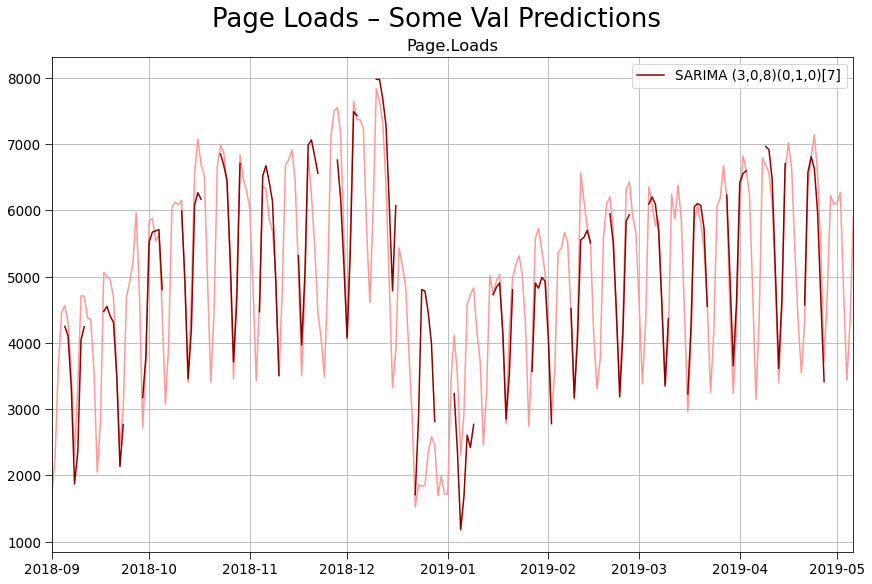

<IPython.core.display.Javascript object>

In [31]:
fig_time_delta = timedelta(days=3)
fig = plot_ground_truth(
    val_intv,
    mode="val",
    data_name=data_name,
)
display(
    plot_model_test_prediction(
        val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

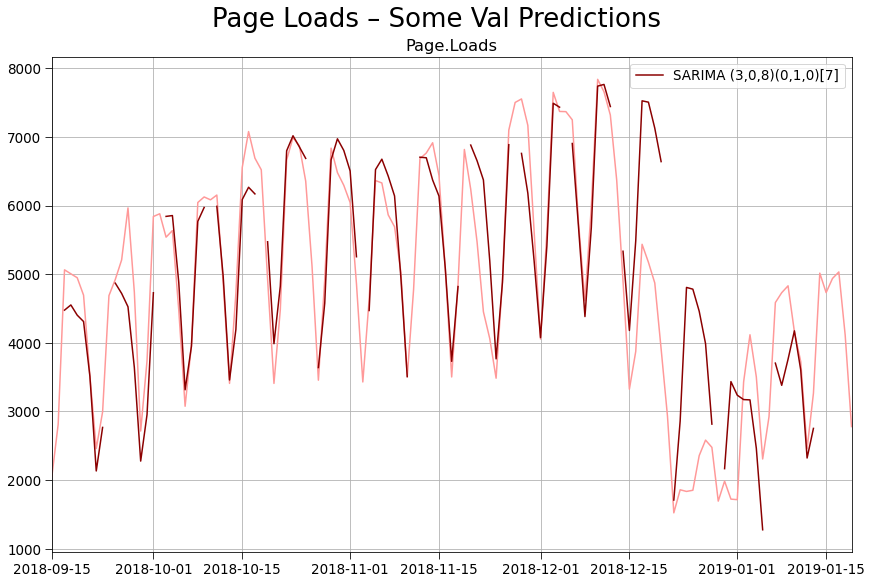

<IPython.core.display.Javascript object>

In [32]:
short_val_intv = tss.Interval(ts, datetime(2018, 9, 15), datetime(2019, 1, 20))
fig_time_delta = timedelta(days=1)
fig = plot_ground_truth(short_val_intv, mode="val", data_name=data_name)
display(
    plot_model_test_prediction(
        short_val_intv,
        fig_time_delta,
        val_preds,
        model_name=model_name,
        model_version=model_version,
        fig=fig,
    )
)

## Test Predictions

In [48]:
%%time
model.update(trans_ts, val_intv)
test_mean_scores, test_all_scores, test_preds = average_scores(
    model,
    trans_ts,
    test_intv,
    trans=trans,
    original_ts=ts,
    scorings=scorings,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(test_mean_scores)
test_results.set_model(model_name, model_version)
test_results.add_model_scores(test_all_scores, test_mean_scores)
test_results.add_model_preds(test_preds)

116/116 – RMSE: 415.85077, MAE: 352.52186, MASE: 0.58415, sMAPE: 9.98638, elapsed time: 8min 26s (last: 4.8s)       
{'MAE': 352.52185685004883,
 'MASE': 0.5841498115401095,
 'RMSE': 415.8507678766239,
 'sMAPE': 9.986377121901569}
CPU times: user 5min 33s, sys: 3min 54s, total: 9min 28s
Wall time: 8min 31s


<IPython.core.display.Javascript object>